# 1. Configuration part

In [ ]:
!cd /content
!wget https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar -xvf spark-3.2.1-bin-hadoop3.2.tgz
!java -version
import os 
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"
!pip install findspark
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

conf = SparkConf()
conf.setMaster("local[*]") \
    .setAppName("project") \
    .set("spark.ui.port", "4050").set("spark.scheduler.mode   ", "")

sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [ ]:
!pip install ipython-autotime
%load_ext autotime

# 2. Loading the data
### this part contains 3 sub-sections:
1. for loading the small dataset
2. for loading the medium dataset
3. for loading the large dataset

The program runs in such a way, that the user can work with one such dataset at a time, since they all have the same variable name: exp_data_small. Therefore, only one of these cells is required to run the program. If the user runs the program once with the small dataset and then wants to run it with the medium dataset, for example, then they would have to run the cell corresponding only to the medium dataset and the remaining of the program.

## 2.1. This is a toy dataset that was used for initial experimentation

In [ ]:
data = spark.read.load("sample_data/happyPath.csv", format="csv", inferSchema=True, header=True)

## 2.2 This is the small and well known dataset titanic.csv


In [ ]:
!wget https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv
exp_data = spark.read.load("titanic.csv", format="csv", inferSchema=True, header=True)
exp_data=exp_data.fillna(-9999999)
exp_data=exp_data.na.fill(-9999999)
exp_data_final = exp_data

## 2.3. This is the medium dataset from IMDB
* It contains the title of movies and some other information. 
* It is 0.1% of the original dataset.

In [ ]:
!wget https://datasets.imdbws.com/title.basics.tsv.gz
!gzip -d title.basics.tsv.gz
exp_data = spark.read.load("title.basics.tsv", format="csv", sep="\t", inferSchema=True, header=True)
exp_data=exp_data.fillna(-9999999)
exp_data=exp_data.na.fill(-9999999)
exp_data_final = exp_data.sample(0.001, seed=111)

## 2.3. This is the large dataset from IMDB
* It is from the same original dataset as the medium one, containing the title of movies and some other information. 
* It is 1% of the original dataset.

In [11]:
!wget https://datasets.imdbws.com/title.basics.tsv.gz
!gzip -d title.basics.tsv.gz
exp_data = spark.read.load("title.basics.tsv", format="csv", sep="\t", inferSchema=True, header=True)
exp_data=exp_data.fillna(-9999999)
exp_data=exp_data.na.fill(-9999999)
exp_data_final = exp_data.sample(0.01, seed=111)

--2022-07-04 10:12:03--  https://datasets.imdbws.com/title.basics.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 18.65.39.47, 18.65.39.122, 18.65.39.113, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|18.65.39.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 158043466 (151M) [binary/octet-stream]
Saving to: ‘title.basics.tsv.gz’

title.basics.tsv.gz 100%[===================>] 150.72M   177MB/s    in 0.9s    

2022-07-04 10:12:04 (177 MB/s) - ‘title.basics.tsv.gz’ saved [158043466/158043466]

gzip: title.basics.tsv already exists; do you wish to overwrite (y or n)? y
y
time: 36.3 s (started: 2022-07-04 10:12:03 +00:00)


# 3. Preprocessing
## Transforming the dataset to numerical values with StringIndexer

In [12]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer

def dataToStringIndexer(d):
    inputs = d.columns
    outputs = [i+"Indexed" for i in inputs]
    indexed = StringIndexer(inputCols=inputs, outputCols=outputs)
    indexedModel = indexed.setHandleInvalid("keep").fit(d)
    d = indexedModel.transform(d)
    d = d.drop(*inputs)

    return d

indexed_data = dataToStringIndexer(exp_data_final)

time: 23.5 s (started: 2022-07-04 10:13:38 +00:00)


In [ ]:
indexed_data.show(2)
indexed_data.count()

+-------------+----------------+-------------------+--------------------+--------------+----------------+--------------+---------------------+-------------+
|tconstIndexed|titleTypeIndexed|primaryTitleIndexed|originalTitleIndexed|isAdultIndexed|startYearIndexed|endYearIndexed|runtimeMinutesIndexed|genresIndexed|
+-------------+----------------+-------------------+--------------------+--------------+----------------+--------------+---------------------+-------------+
|          0.0|             1.0|             4403.0|              4406.0|           0.0|           118.0|           0.0|                  0.0|         93.0|
|          1.0|             1.0|              744.0|               737.0|           0.0|            74.0|           0.0|                 22.0|         12.0|
+-------------+----------------+-------------------+--------------------+--------------+----------------+--------------+---------------------+-------------+
only showing top 2 rows



8989

time: 3.97 s (started: 2022-07-02 21:03:38 +00:00)


# 4. Baseline: k-means

## 4.1. Pre-process the data for k-means

In [13]:
from pyspark.ml.feature import VectorAssembler, VectorIndexer, StandardScaler

def dataAssembler(indexed):
    data_assembled = VectorAssembler(inputCols=indexed.columns,outputCol="features").transform(indexed)
    data_assembled = data_assembled.drop(*indexed.columns)
    return data_assembled

data_assembled = dataAssembler(indexed_data)

time: 934 ms (started: 2022-07-04 10:14:01 +00:00)


## 4.2. Estimate silhouette scores for up to 14 different number of clusters

In [16]:

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from math import sqrt

def estimateSilhouetteScores(assembled, range_start, range_stop, range_step):
    silhouette_scores = {}    
    evaluator = ClusteringEvaluator(featuresCol='features', \
                metricName='silhouette', distanceMeasure='squaredEuclidean')

    ks = [i for i in range(range_start, range_stop, range_step)]
    for K in range(range_start, range_stop, range_step):
        KMeans_ = KMeans(featuresCol='features', k=K, maxIter=5)
        KMeans_fit = KMeans_.fit(assembled)
        km_trans = KMeans_fit.transform(assembled) 
        evaluation_score = evaluator.evaluate(km_trans)
        silhouette_scores[K] = evaluation_score
    
    return silhouette_scores, ks

sil, ks = estimateSilhouetteScores(data_assembled, 2, 15, 1)

time: 33min 23s (started: 2022-07-04 10:16:09 +00:00)


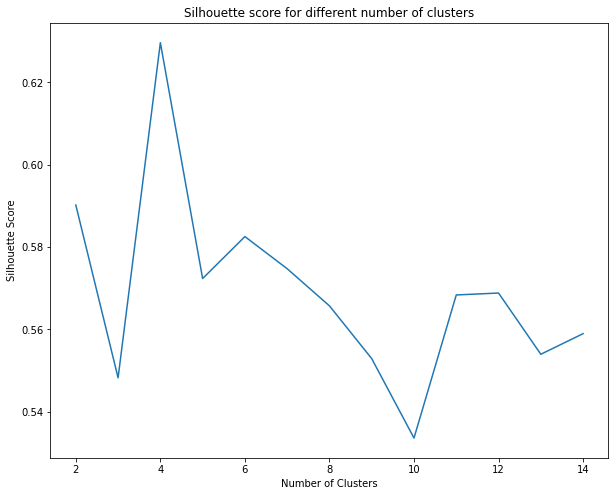

time: 298 ms (started: 2022-07-04 10:49:32 +00:00)


In [17]:
import matplotlib.pyplot as plt

def plotSilhouette(sil, ks):
    fig, ax = plt.subplots(1,1, figsize =(10,8))
    ax.plot(ks, list(sil.values()))
    ax.set_title("Silhouette score for different number of clusters")
    ax.set_xlabel('Number of Clusters')
    ax.set_ylabel('Silhouette Score')

plotSilhouette(sil, ks)

## 4.3. Run k-means with a selected k
The k is to be decided by the user based on this plot and the elbow method. An example is shown as a comment for k = 7

In [18]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from math import sqrt

def runKMeans(df, k):
    # run k means based on the selected number of k
    KMeans_ = KMeans(featuresCol='features', k=k)
    KMeans_fit = KMeans_.fit(df)
    km_trans = KMeans_fit.transform(df)
    km_trans = km_trans.drop("features")
    return km_trans

# data_pred = runKMeans(data_assembled, 7)

time: 6.44 ms (started: 2022-07-04 10:49:32 +00:00)


## 4.4. Add the prediction column to the indexed dataset

In [19]:
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window


def addPrediction(indexedDF, kmDF):
    # since there is no common column between these two dataframes add row_index so that they can be joined
    x=indexedDF.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
    y=kmDF.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
    x = x.join(y, on=["row_index"]).drop("row_index", "features")
    return x

# added_prediction = addPrediction(indexed_data, data_pred)
# added_prediction.show(5)

time: 7.83 ms (started: 2022-07-04 10:49:32 +00:00)


## 4.5. Create different datasets based on the groups determined by k-means and calculate the homogeneity of each group, as well as the average homogeneity.

In [20]:
def groupDF(indexedDF, k):
    ds = {}
    for i in range(k):
        di = indexedDF.filter(indexedDF.prediction == i)
        ds[i] = di
    return ds

time: 3.24 ms (started: 2022-07-04 10:49:32 +00:00)


In [21]:
from itertools import chain
from collections import Counter
from pyspark.sql.functions import col, lit, create_map, explode

def hom_rdd(df):
    key_values = create_map(*(chain(*[(lit(name), col(name)) for name in df.columns])))
    df_new = df.select(explode(key_values))
    nrows = df.count()
    x = df_new.rdd.groupByKey() \
                        .mapValues(list) \
                        .map(lambda x: (x[0], Counter(x[1]).most_common(1))) \
                        .map(lambda x: (x[0], x[1][0][1])) \
                        .map(lambda x: (x[0], x[1] if x[1] > 1 else 0)) \
                        .map(lambda x: (x[0], x[1]/nrows))

    attrs = x.map(lambda x: x[0]).collect()
    homs = x.map(lambda x: x[1]).collect()
    hom_of_df = x.map(lambda x: x[1]).mean()

    return hom_of_df, dict(zip(attrs, homs))


def homD(ds):
    """ds: a dictionary with one entry for each cluster df"""
    clusters_hom = {}
    for i in range(len(ds)):
        clusters_hom[i] = hom_rdd(ds[i])[0]
    return sum(clusters_hom.values()) / len(clusters_hom)

time: 28.8 ms (started: 2022-07-04 10:49:32 +00:00)


In [ ]:
def runSeveralK(assembled_data, indexed_data, ks):
    """Returns a dictionary
    key: the number of clusters
    value: the average homogeneity across all clusters"""

    Kmeans_Results={}
    for k in ks:
        print("now at", k, "clusters")
        data_pred = runKMeans(assembled_data, k)
        d = addPrediction(indexed_data, data_pred)
        ds = groupDF(d, k)
        Kmeans_Results[k] = homD(ds)

    return Kmeans_Results

KMeans_Result = runSeveralK(data_assembled, indexed_data, ks)

# 5. Our proposed solution: the Tree Algorithm

In [18]:
import numpy as np
from itertools import chain
from collections import Counter
from pyspark.sql.functions import col, lit, create_map, explode
import pyspark.sql.functions as F

class Node:
    def __init__(self, df=None, feature=None, query="", hom_measure=None, leaf=True, left_child=None, right_child=None):
        self.df = df
        self.feature = feature
        self.left_child = left_child
        self.right_child = right_child
        self.hom_measure = hom_measure
        self.leaf = leaf

class TreeAlgorithm:
    def __init__(self, df, limit=None):
        self.nrows = df.count()
        self.df = df
    
    def hom(self, df):
        """df: the indexed data"""
        df = df.drop("prediction", "scaledFeatures")
        nrows = df.count()
        hom = 0
        cols = df.columns
        hom_per_column = {}
        for i in cols:
            c = df.groupBy(i).count().agg({"count": "max"}).collect()[0]["max(count)"]
            if c == 1 and nrows > 1:
                c = 0
            hom_per_column[i] = c / nrows
            hom += c/nrows
        return hom/len(cols), hom_per_column
    
    def hom_rdd(self, df):
        key_values = create_map(*(chain(*[(lit(name), col(name)) for name in df.columns])))
        df_new = df.select(explode(key_values))
        nrows = df.count()
        x = df_new.rdd.groupByKey() \
                            .mapValues(list) \
                            .map(lambda x: (x[0], Counter(x[1]).most_common(1))) \
                            .map(lambda x: (x[0], x[1][0][1])) \
                            .map(lambda x: (x[0], x[1] if x[1] > 1 else 0)) \
                            .map(lambda x: (x[0], x[1]/nrows))

        attrs = x.map(lambda x: x[0]).collect()
        homs = x.map(lambda x: x[1]).collect()
        hom_of_df = x.map(lambda x: x[1]).mean()

        return hom_of_df, dict(zip(attrs, homs))
    
    def setHardLimit(self, limit):
        """returns the minimum number of rows that are required for every group"""
        self.limit = int(self.df.count() * limit)

    def isValidSplit(self, hom_val, hard_limit, node_df):
        node_rows = node_df.count()
        return ((node_rows * hom_val) >= hard_limit) and ((node_rows * (1-hom_val)) >= hard_limit)

    def getHomMeasure(self, node_df):
        return self.hom_rdd(node_df)[0]

    def tree_grow(self, dataframe):
        hom_of_root = self.hom_rdd(dataframe)[1] # this is the dictionary
        node = Node(dataframe, hom_measure=None)
        node_list = [node]
        tree = []
        node_limit = self.limit
        c2 = 0
        while len(node_list) != 0:
            # print("now at split:", c2+1)
            current_node = node_list.pop(0)      
            single_hom_val, hom_node = self.hom_rdd(current_node.df) # val, dict with hom for each column
            ordered_hom_list = sorted(list(hom_node.items()), key = lambda x: x[1], reverse=True)
            c = 0
            isLeaf = True
            # hom_val_tuple: (col_name, hom_of_col)
            for hom_val_tuple in ordered_hom_list:
                if self.isValidSplit(hom_val_tuple[1], node_limit, current_node.df):
                    isLeaf = False

                    my_val = current_node.df.groupBy(hom_val_tuple[0]) \
                                             .count() \
                                             .orderBy(F.desc("count")) \
                                             .select(hom_val_tuple[0]) \
                                             .collect()[0][hom_val_tuple[0]]

                    left_child_df = current_node.df.filter(hom_val_tuple[0] + "== " + str(my_val))
                    right_child_df = current_node.df.filter(hom_val_tuple[0] + "!= " + str(my_val))
                    
                    left_query = "select * from DATABASE_NAME\n " +\
                                 "where " + str(hom_val_tuple[0]) + " == " + str(my_val)
                    
                    right_query = "select * from DATABASE_NAME\n " +\
                                  "where " + str(hom_val_tuple[0]) + " != " + str(my_val)
                    
                    left_child_node = Node(left_child_df)
                    right_child_node = Node(right_child_df)

                    node_list.append(left_child_node)
                    current_node.left_child = left_child_node
                    
                    node_list.append(right_child_node)
                    current_node.right_child = right_child_node

                    current_node.feature = hom_val_tuple[0]
                    current_node.leaf = False

                    left_child_node.query = left_query
                    right_child_node.query = right_query
                    tree.append(current_node)
                    c += 1
                    break
            c2 += 1
            if isLeaf:
                tree.append(current_node)
                current_node.leaf = True
                current_node.hom_measure = single_hom_val

        return tree   

time: 152 ms (started: 2022-07-04 08:52:36 +00:00)


In [ ]:
# 0.05, 0.1,
limits = [0.15, 0.2, 0.25, 0.30, 0.35]
results = {}
hom_dict = {}
leaves_dict = {}
for i in range(len(limits)):
    print("now at limit:", i+1, "out of", len(limits))
    algo = TreeAlgorithm(indexed_data)
    algo.setHardLimit(limits[i])
    tree = algo.tree_grow(indexed_data)
    r = sc.parallelize([i.hom_measure for i in tree if i.leaf == True])
    results[limits[i]] = r.mean()
    hom_dict[limits[i]] = r.mean()
    leaves_dict[limits[i]] = r.count()

In [ ]:
%%timeit
limits = [0.05,0.07,0.1,0.15,0.2,0.25,0.26,0.27,0.28,0.33]
results={}
for i in range(len(limits)):
    print("now at limit:", i+1, "out of", len(limits))
    algo = TreeAlgorithm(indexed_data)
    algo.setHardLimit(limits[i])
    tree = algo.tree_grow(indexed_data)
    r = sc.parallelize([i.hom_measure for i in tree if i.leaf == True])
    results[limits[i]]=r.mean()

In [ ]:
def createPlots(dataset_size: str, km_results: dict, tree_results: dict):
    fig = plt.figure(figsize=(13, 5))

    plt.subplot(1, 2, 1)
    plt.plot(list(km_results.keys()), list(km_results.values()))
    plt.title("k-means")
    plt.xlabel("number of clusters")
    plt.ylabel("homogeneity score")
    plt.ylim(0.3, 0.6)

    plt.subplot(1, 2, 2)
    plt.plot(list(tree_results.keys()), list(tree_results.values()))
    plt.title("treeAlgorithm")
    plt.xlabel("hard limit for splitting the tree")
    plt.ylabel("homogeneity score")
    plt.ylim(0.3, 0.6)
    plt.savefig(dataset_size + ".png")
    plt.show()

createPlots("large_dataset", KMeans_Result, results)

Text(0, 0.5, 'Hom value')

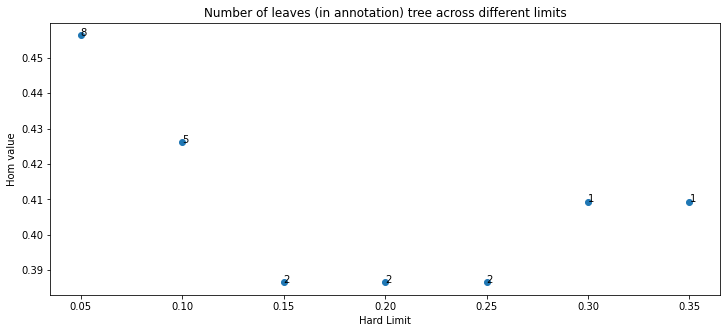

time: 177 ms (started: 2022-07-03 00:52:46 +00:00)


In [ ]:
#Hom and amount of leaves it creates
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
ax.scatter(list(leaves_dict.keys()), list(hom_dict.values()))

for i, txt in enumerate(list(leaves_dict.values())):
    ax.annotate(txt, (list(leaves_dict.keys())[i], list(hom_dict.values())[i]))

plt.title("Number of leaves (in annotation) tree across different limits")
plt.xlabel("Hard Limit")
plt.ylabel("Hom value")

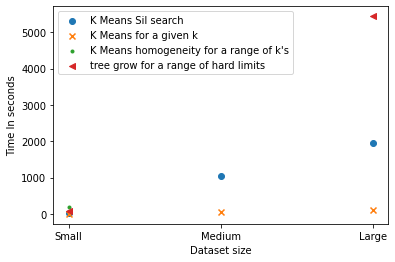

time: 224 ms (started: 2022-07-02 20:47:24 +00:00)


In [ ]:
import matplotlib.pyplot as plt
names=["Small","Medium","Large"]
KMeans_Search=[21.8,1047,1948]
KMeans_SpecificValue=[1.1,59.3,115]
Finding_Hom_For_Every_Value=[194,None,None]
treeGrowPlot=[87,None,5439]
fig, ax = plt.subplots()
ax.scatter(names, KMeans_Search,marker="o",label="K Means Sil search")
ax.scatter(names, KMeans_SpecificValue,marker="x",label="K Means for a given k")
ax.scatter(names, Finding_Hom_For_Every_Value,marker=".",label="K Means homogeneity for a range of k's")
ax.scatter(names, treeGrowPlot,marker="<",label="tree grow for a range of hard limits")
plt.ylabel("Time In seconds")
plt.xlabel("Dataset size")
ax.legend(loc='best')